<a href="https://colab.research.google.com/github/adelsakkir/Parallel-Scheduling-MILP/blob/main/Sched_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Defining Classes

In [2]:
# Step 1: Build the dataset
import random
import copy
import pandas as pd
import numpy as np
# import gymnasium as gym
# from gymnasium import spaces
from math import comb
import itertools
#from problem_classes import Job, Machine, SchedulingEnvironment # , State

In [3]:
import random
import copy
import numpy as np
#import gymnasium as gym
#from gymnasium import spaces


# Family approach
class Job:
    def __init__(self, id, priority, family):
        self.id = id
        self.priority = priority
        #self.due_date = due_date
        self.family = family
        self.allocation_status = 0
        self.machine_allocated = 0
        self.start_time = None
        self.end_time = None

class Machine:
    def __init__(self, id, family_dict):
        self.id = id
        self.families = list(family_dict.keys())
        self.processing_times = family_dict
        self.schedule = []
        self.end_time = 0
        self.busyness = {family: 0 for family in self.families} # Keep track of how many jobs of each family are allocated to this machine

class State:
    def __init__(self, jobs, machines):
        self.machines = machines
        self.remaining_jobs =  jobs
        self.available_actions = self.get_available_actions()
        self.all_families = self.get_all_families()

        # Vector: jobs per family
        self.jobs_per_family = self.create_jobs_per_family_vector()

        # Matrix: machine busyness
        self.machine_busyness_matrix = self.create_machine_busyness_matrix()

        self.priority_processing_time = self.create_priority_processing_time_vector()

    # available action is a list of (job, machine) pairs
    def get_available_actions(self):
        available_actions = []
        for job in self.remaining_jobs:
            for machine in self.machines:
                if job.family in machine.families:
                    available_actions.append((job, machine))
        return available_actions

    def print_available_actions(self):
        for job, machine in self.available_actions:
            print(f"Job {job.id}   Machine {machine.id}")

    def get_all_families(self):
        all_families = []
        for machine in self.machines:
            all_families += machine.families
        return sorted(list(set(all_families)))

    def count_jobs_per_family(self):
        job_counts_dict = {family: 0 for family in self.all_families}

        for job in self.remaining_jobs:
            family = job.family

            if family not in job_counts_dict:
                job_counts_dict[family] = 0

            job_counts_dict[family] += 1

        return job_counts_dict

    def create_jobs_per_family_vector(self):
        job_counts_dict = self.count_jobs_per_family()
        job_counts_list = [job_counts_dict[family] for family in job_counts_dict]
        return np.array(job_counts_list)

    def create_machine_busyness_matrix(self):
        num_families = len(self.all_families)
        num_machines = len(self.machines)

        # Create a matrix based on the current busyness of each machine
        machine_busyness_matrix = np.zeros((num_machines, num_families))

        # Populate the matrix using the busyness dictionary from each machine
        for machine_index, machine in enumerate(self.machines):
            for family_index, family in enumerate(self.all_families):
                if family in machine.busyness:
                    machine_busyness_matrix[machine_index][family_index] = machine.busyness[family]

        return machine_busyness_matrix

    def create_priority_processing_time_vector(self):
        num_machines = len(self.machines)
        priority_processing_time = np.zeros(num_machines)

        for i, machine in enumerate(self.machines):
            for job in machine.schedule:
                if job != 0:
                    family = job.family
                    priority_processing_time[i] += machine.processing_times[family] * job.priority
                    priority_processing_time[i] += job.end_time * job.priority

        return np.array(priority_processing_time)

    def get_feature_vector(self):
        return np.concatenate((self.jobs_per_family, self.machine_busyness_matrix.flatten(), self.priority_processing_time))

    def display_state(self):
        # Display remaining jobs
        print('Remaining jobs:', [job.id for job in self.remaining_jobs])

        # Display the machines and their allocated jobs
        print('Machines:')
        for machine in self.machines:
            schedule_ids = []
            for job in machine.schedule:
                if job == 0:
                    schedule_ids.append(0)
                else:
                    schedule_ids.append(job.id)

            print(f'Machine {machine.id}: {schedule_ids}')

        # Display the vector of jobs per family
        print('Jobs per family:', self.jobs_per_family)

        # Display the matrix for machine busyness
        print('Machine business:', self.machine_busyness_matrix)

        # Display the vector of priority processing times
        print('Priority processing time:', self.priority_processing_time)

class SchedulingEnvironment:
    def __init__(self, jobs, machines):
        self.machines = machines
        self.jobs = jobs
        self.current_state = State(self.jobs, self.machines)

    def reset(self):
        for machine in self.machines:
            machine.schedule = []
            machine.end_time = 0
            machine.busyness = {family: 0 for family in machine.families}

        for each_job in self.jobs:
            each_job.allocation_status = 0
            each_job.machine_allocated = 0
            each_job.start_time = None
            each_job.end_time = None


        self.current_state = State(self.jobs, self.machines)
        return self.current_state

    def step(self, action):
        """
        Parameters:  action (a tuple of (job, machine)))
        Returns: next_state, reward, done
        """
        done = False
        job, machine = action

        # Add a job to the machine schedule
        machine.schedule.append(job)

        # Update the job's allocation status
        job.allocation_status = 1
        job.machine_allocated = machine

        # Calculate start and end times based on the recipes
        job.start_time = machine.end_time
        job.end_time = job.start_time + machine.processing_times[job.family]
        machine.end_time += machine.processing_times[job.family]

        # Update the machine's busyness
        if job.family in machine.busyness:
            machine.busyness[job.family] += 1
        else:
            machine.busyness[job.family] = 1


        # Calculate the reward
        reward = 0

        # Update the remaining jobs
        updated_remaining_jobs = [j for j in self.current_state.remaining_jobs if j.allocation_status == 0]

        # Update the machines
        updated_machines = list(self.machines)

        next_state = State(updated_remaining_jobs, updated_machines)

        if len(next_state.remaining_jobs)==0:
            done = True

        reward = (job.priority) * job.end_time # NEED TO CHANGE THIS TO THE ACTUAL REWARD
        self.current_state = next_state

        return next_state, reward, done


#DQN Network

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple

# Define the DQN network
# class DQN(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 32)
#         self.fc2 = nn.Linear(32, 16)
#         self.fc3 = nn.Linear(16, output_size)

#     def forward(self, x):
#         m = nn.LeakyReLU(0.1)
#         #F.relu
#         x = m(self.fc1(x))
#         x = m(self.fc2(x))
#         return self.fc3(x)

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        # self.fc2 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_size)

    def forward(self, x):
        m = nn.LeakyReLU(0.1)
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
        x = m(self.fc4(x))
        # x = m(self.fc5(x))
        return self.fc5(x)


#Replay Buffer

In [52]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the replay buffer
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

#DQN Agent

In [72]:
# Define the DQN agent
class DQNAgent:
    def __init__(self, input_size, output_size, jobs, machines, batch_size=16, gamma=0.9, epsilon_start=0.9, epsilon_end=0.1, epsilon_decay=0.995):
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(input_size, output_size).to(self.device)
        self.target_net = DQN(input_size, output_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        # print("Policy Net state dict", self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayBuffer(100000)
        #self.memory = PrioritizedReplayBuffer(10000)

        self.steps_done = 0
        #------------------------------------------------------------

        self.jobs = jobs
        self.machines = machines
        self.num_jobs = len(jobs)
        self.num_machines = len(machines)

    def select_action(self, state):
        sample = random.random()
        self.epsilon = max(self.epsilon_end, self.epsilon_decay * self.epsilon)

        if sample > self.epsilon:
            with torch.no_grad():
                state_format = torch.tensor(state.get_feature_vector(), dtype=torch.float32).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_format)
                q_array = q_values.numpy()[0]
                best_action = None
                best_action_value = 1000000000000
                for action_index in range(len(q_array)):
                    if q_array[action_index] <= best_action_value and self.find_action_from_index(action_index) in state.available_actions:
                        best_action = self.find_action_from_index(action_index)
                        best_action_value = q_array[action_index]
                # action_index = q_values.argmin(dim=1).item()
                action = best_action
        else:
            action = random.choice(state.available_actions)

        return action

    def find_action_from_index(self, index):
        job_id = (index%self.num_jobs) +1
        machine_id = (index//(self.num_jobs))+1
        # print(self.num_jobs, machine_id)

        return (self.jobs[job_id-1], self.machines[machine_id-1])

    def find_index_from_action(self, action):
        action_job_id = action[0].id
        action_machine_id = action[1].id

        start_index = 0
        for mach in self.machines:
            if action_machine_id == mach.id:
                break
            else:
                start_index += self.num_jobs
        index = start_index + (action_job_id-1)
        return index

    def test_select_action(self, state):
      with torch.no_grad():
          state_format = torch.tensor(state.get_feature_vector(), dtype=torch.float32).unsqueeze(0).to(self.device)
          q_values = self.policy_net(state_format)
          q_array = q_values.numpy()[0]
          best_action = None
          best_action_value = 1000000000000
          for action_index in range(len(q_array)):
              if q_array[action_index] <= best_action_value and self.find_action_from_index(action_index) in state.available_actions:
                  best_action = self.find_action_from_index(action_index)
                  best_action_value = q_array[action_index]
          # action_index = q_values.argmin(dim=1).item()
          action = best_action
      return action


    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state.get_feature_vector(), self.find_index_from_action(action), reward, next_state.get_feature_vector(), done)
    #------------------------------------------------------------
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        # print ("Transistions: ", transitions)
        batch = Transition(*zip(*transitions))
        # print ("batch: ", batch)

        non_final_mask = torch.tensor(tuple(map(lambda s: not s, batch.done)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.tensor([s for s, d in zip(batch.next_state, batch.done) if not d],
                                             dtype=torch.float32).to(self.device)
        # print("Non final next states ", non_final_next_states)
        state_batch = torch.tensor(batch.state, dtype=torch.float32).to(self.device)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1).to(self.device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        # print("State Batch: ", state_batch)
        # print("Action Batch: ", action_batch)
        # print("Reward Batch: ", reward_batch)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        # print ("Batch Size: ", self.batch_size)
        # print ("State action values: ", state_action_values)

        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    #------------------------------------------------------------
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        self.policy_net.load_state_dict(torch.load(path))


#Plotting Loss

In [54]:
import matplotlib.pyplot as plt
from IPython import display

def visualize_loss(loss_values):
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.clf()
  plt.title('Training...')
  plt.xlabel('Number of Episodes')
  plt.ylabel('Loss Value')
  plt.plot(range(len(loss_values)), loss_values)
  plt.ylim(ymin=0)
  plt.show(block=False)

#Instantiating the Problem and environment

In [73]:
# Define the problem: 10 jobs, 3 machines, 4 recipies

# index, priority, family
job1 = Job(1, 10, "R1")
job2 = Job(2, 8, "R3")
job3 = Job(3, 12, "R3")
job4 = Job(4, 6, "R4")
job5 = Job(5, 10, "R2")
job6 = Job(6, 12, "R1")
job7 = Job(7, 12, "R3")
job8 = Job(8, 6, "R4")
job9 = Job(9, 8, "R2")
job10 = Job(10, 10, "R1")
job11 = Job(11, 12, "R2")
job12 = Job(12, 10, "R1")
job13 = Job(13, 8, "R3")
job14 = Job(14, 14, "R3")
job15 = Job(15, 12, "R1")
job16 = Job(16, 8, "R2")
job17 = Job(17, 14, "R1")
job18 = Job(18, 10, "R4")
job19 = Job(19, 12, "R1")
job20 = Job(20, 8, "R3")

# A list of job objects
# job_list = [job1, job2, job3, job4, job5, job6, job7, job8, job9, job10]
job_list = [job1, job2, job3, job4, job5, job6, job7, job8, job9, job10, job11, job12, job13, job14, job15]
            #, job16, job17, job18, job19, job20]

# Define some machines
machine1 = Machine(1, {"R1":14,"R4":50})
machine2 = Machine(2, {"R2":10,"R3":20})
machine3 = Machine(3, {"R1": 15,"R2":30,"R3":10})
# machine4 = Machine(4, {"R1": 25,"R2":10,"R3":20,"R4":20})

# A list of machine objects
machine_list = [machine1, machine2, machine3]
# machine_list = [machine1, machine2, machine3, machine4]

#Greedy Agent

In [74]:
class greedy_agent:
    def __init__(self):
        pass

    def select_action(self, state):
        best_cost = 1000000
        greedy_action = None
        # state.print_available_actions()
        for job, machine in state.available_actions:
            # print(job.id, job.due_date, machine.id, machine.end_time+job.processing_times[machine.id])
            if (job.priority)*(machine.end_time+machine.processing_times[job.family]) <= best_cost:
                greedy_action =(job, machine)
                best_cost = (job.priority)*(machine.end_time+machine.processing_times[job.family])
        # print("Greedy Action: ", greedy_action[0].id, greedy_action[1].id)
        return greedy_action

In [75]:
env = SchedulingEnvironment(job_list, machine_list)
agent = greedy_agent()
obs = env.reset()
total_reward = 0
current_state = env.reset()
done = False
t=0
while not done:
    action = agent.select_action(obs)
    next_state, reward, done = env.step(action)
    env.current_state =next_state
    total_reward += reward
    obs = next_state
    # obs.display()
    if done:
        obs.display_state()
        print("Total Reward: ", total_reward)
        break

Remaining jobs: []
Machines:
Machine 1: [12, 10, 8, 4]
Machine 2: [9, 5, 11, 3, 14]
Machine 3: [13, 2, 1, 7, 15, 6]
Jobs per family: [0 0 0 0]
Machine business: [[2. 0. 0. 2.]
 [0. 3. 2. 0.]
 [3. 0. 3. 0.]]
Priority processing time: [2536. 3040. 3540.]
Total Reward:  6626


# DQN Training

<Figure size 640x480 with 0 Axes>

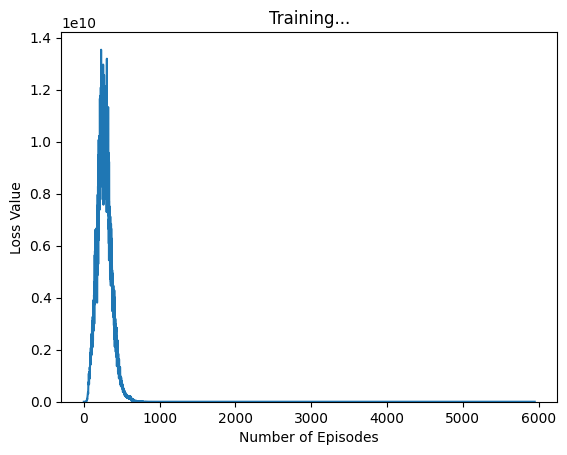

Episode 5951: Model loss = 411.1126403808594


In [80]:
env = SchedulingEnvironment(job_list, machine_list)
input_size = 4 + (len(machine_list)*4) + len(machine_list)
output_size = len(job_list)*len(machine_list)
agent = DQNAgent(input_size, output_size, job_list, machine_list)

# Training loop
num_episodes = 6000
loss_list = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)

        env.current_state = next_state
        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.optimize_model()  # Get the model loss value

        total_reward = reward
        state = next_state
        if done:
            agent.update_target_network()
            break
    loss_list.append(loss)
    if loss != None and episode % 50 == 0 : #and episode >500
        visualize_loss(loss_list)
        print(f"Episode {episode + 1}: Model loss = {loss}")


# Save the trained model
agent.save_model("sched_dqn_model.pth")


In [81]:
#Loading the trained model
agent.load_model("sched_dqn_model.pth")


def get_best_schedule(agent, env):
  state = env.reset()
  done = False
  total_reward  = 0

  while not done:
    action = agent.test_select_action(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    state = next_state
  print(next_state.display_state())

  return total_reward

tot_reward = get_best_schedule(agent, env)
print("Total Reward: {}".format(tot_reward))



Remaining jobs: []
Machines:
Machine 1: [6, 10, 8, 4]
Machine 2: [9, 11, 3, 5, 14]
Machine 3: [13, 12, 2, 7, 1, 15]
Jobs per family: [0 0 0 0]
Machine business: [[2. 0. 0. 2.]
 [0. 3. 2. 0.]
 [3. 0. 3. 0.]]
Priority processing time: [2592. 3100. 3410.]
None
Total Reward: 6614
